In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import open3d as o3d
from pyntcloud import PyntCloud
import glob
import plyfile as ply
from tqdm import tqdm
import pandas as pd

## Projection of 3D points onto 2D image plane

Following the same idea proposed in [1] and [2] we propose a method to project 3D points onto a 2D image plane by means of a spherical coordinate system. 
The idea is the following:
1) Given a 3D point $P$ we can compute its spherical coordinates $\theta$, $\phi$, $r$ as follows:
    $$\theta = \arctan(\frac{P_y}{P_x})$$
    $$\phi = \arctan(\frac{P_z}{\sqrt{P_x^2 + P_y^2}})$$
    $$r = \sqrt{P_x^2 + P_y^2 + P_z^2}$$

2) Define a 2D grid for the angles $\theta$, $\phi$ by assigning a value of 'pixel size' (e.g. 1 degree) and a range of values for $\theta$ and $\phi$ (e.g. $\theta \in [-\pi/2, \pi/2]$ and $\phi \in [0, 2\pi]$).

3) for each pixel defined in the grid, assign the value $r$ of the 3D point $P$ that is closest to the pixel center.
    
4) The obtained 2D images looses the depth information, of points hidden behind the closest surface, but we assume that in an autonomous driving scenario, the most important information is the distance to the closest obstacle.

Note that, in order to reduce the loss of points behind the closest surface, it is still possible to define a quantization in the radius. In this way we wouls end up with a series of surfaces, each of which refers to a different layer of distance from the observer

In [3]:
# pixel sizes on which we want to compress the point cloud (in degrees)
pixel_sizes = [(1,1), (2,2), (5,5)]

# create the corresponding folders
main_out_dir = "2DRepresentation"
out_dirs = [os.path.join(main_out_dir, str(pixel_size[0]) + "_" + str(pixel_size[1])) for pixel_size in pixel_sizes]
for out_dir in out_dirs:
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

In [4]:
# take all top lidars and convert them into images
main_dir = "dataset-downloader-kit/CV/dataset/Town01_Opt_ClearSunset/LIDAR_TOP"
N_point_clouds = 10

# get all the files in the directory
files = np.sort(glob.glob(main_dir + "/*.ply"))
files = files[:5*N_point_clouds]

In [7]:
def get_labels (path, save=False):
    plydata = ply.PlyData.read(path)
    labels = np.array(plydata.elements[0].data['ObjTag'])
    if save:
        np.save(path.split('.')[0] + '_labels.npy', labels)
    return labels
    
def get_images (
    path: str,
    theta_range:tuple = (-np.pi/4, np.pi/4), 
    phi_range:tuple = (0, 2*np.pi),
    pixel_size:tuple = (2, 2),
    stepR:int= None,
    ):
    """
    path: path to the ply file
    theta_range: range of theta to consider
    phi_range: range of phi to consider
    pixel_size: size of the pixel in degrees    

    returns:
    dictionary with 
        - key: label of the object
        - value: 2d representation of the object 
    """
    # load point cloud and labels
    pc = o3d.io.read_point_cloud(path, format='ply')
    labels = get_labels(path)
    all_points = np.asarray(pc.points)
    x, y, z = all_points[:, 0], all_points[:, 1], all_points[:, 2]
    
    # get spherical coordinates
    r = np.sqrt(x**2 + y**2 + z**2)

    # theta = np.zeros(len(x))
    theta =  np.arctan(z , np.sqrt(x**2 + y**2)) # -pi/2, pi/2

    # we want a 360 range phi
    phi = np.zeros(len(x))
    mask = np.logical_and (x >= 0, y >= 0)
    xs = x[mask]
    ys = y[mask]
    phi[mask] = np.arctan(ys, xs) # ranges 0, pi/2

    mask = x < 0
    xs = x[mask]
    ys = y[mask]
    phi[mask] = np.arctan(ys, xs) + np.pi # ranges pi/2, pi

    mask = np.logical_and (x>=0, y < 0)
    xs = x[mask]
    ys = y[mask]
    phi[mask] = np.arctan(ys, xs) + 2*np.pi # ranges pi, 3pi/2


    # define the grid
    pixel_size_rad = (np.deg2rad(pixel_size[0]), np.deg2rad(pixel_size[1]))
    
    phi_grid = np.arange(phi_range[0], phi_range[1]+1, pixel_size_rad[0])

    theta_grid = np.arange(theta_range[0], theta_range[1]+1, pixel_size_rad[1])

    # get all the labels and image
    all_labels = np.unique(labels)

    result = dict()

    for l in all_labels:
        lmask = labels == l

        
        rs_class = r[lmask]

        if stepR is not None:
            rs_pixels_min = np.min(rs_class)
            rs_pixels_max = np.max(rs_class)
            step_size_r = (rs_pixels_max - rs_pixels_min)/stepR
            rs_pixel_bounds = [rs_pixels_min + i*step_size_r for i in range(stepR+1)]

            result[l] = dict ()

            for k, r_min in enumerate(rs_pixel_bounds):
                img = np.zeros((len(phi_grid), len(theta_grid)))
                for i, ph in enumerate(phi_grid):
                    for j, th in enumerate(theta_grid):

                        tmask = np.logical_and(theta>=th, theta<th+pixel_size[1])
                        pmask = np.logical_and(phi>=ph, phi<ph+pixel_size[0])

                        rs_pixel = r[tmask & pmask & lmask]
                        

                        if len(rs_pixel) > 0:
                            # print (f"pixel {i,j} has {len(rs_pixel)} points, min distance {np.min(rs_pixel)}")
                            min_index = np.argmin(rs_pixel)

                            img[i,j] = rs_pixel[min_index]
                result[l]["r_min_%d"%k] = img 
        else:
            img = np.zeros((len(phi_grid), len(theta_grid)))
            for i, ph in enumerate(phi_grid):
                for j, th in enumerate(theta_grid):

                    tmask = np.logical_and(theta>=th, theta<th+pixel_size[1])
                    pmask = np.logical_and(phi>=ph, phi<ph+pixel_size[0])

                    rs_pixel = r[tmask & pmask & lmask]
                    

                    if len(rs_pixel) > 0:
                        # print (f"pixel {i,j} has {len(rs_pixel)} points, min distance {np.min(rs_pixel)}")
                        min_index = np.argmin(rs_pixel)

                        img[i,j] = rs_pixel[min_index]
            result[l] = img
    return result

### No radius quantization

In this case we assume that the radius is not quantized, so we have a panoramic at one layer for each run.
In particular, we project the 3D points into a 2D image for each class, this allows to reduce the loss of information due to the non quantization of the radius.

To sum up, we follow the following steps:

1) For each class, select the points belonging to the class and project them into a 2D image. We obtain a set of 2D images for each point cloud, each of which represents the closest surface for each class.

2) Each image can be compressed by means of any image compression algorithm (e.g. JPEG, PNG, etc.) and stored in a file.

3) By knowing the grid quantization of angles $\theta$, $\phi$ and the radius, it is possible to reconstruct the 3D point cloud from the 2D images.


We repeat these steps for each point cloud, with 3 different pixel quantizations: 1 degree, 2 degrees and 5 degrees, for both the angles $\theta$, $\phi$ .

In [ ]:

# let us run a test without radius grid 
step_radius = None
pixel_sizes = [(1,1,), (2,2), (5,5,)]

for ps, od in zip(pixel_sizes, out_dirs):
    print ("Processing pixel size: ", ps)
    for f in tqdm(files):
        # image name 
        image_name = f.split("/")[-1].split(".")[0]

        # dictionary of key-value pairs: key is the label, value is the image itself
        im = get_images (
            path=f,
            theta_range=(-np.pi/4, np.pi/4), 
            phi_range=(0, 2*np.pi),
            pixel_size=ps,
            stepR=step_radius
            )
        save_folder = os.path.join(od, f"{image_name}")
        
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        for k, v in im.items():
            # save txt file
            np.savetxt(os.path.join(save_folder, f"{image_name}_{k}.txt"), v, fmt="%d")


#### Visualization of the 2D images

Let us visualize the 2D images obtained for the 3 different pixel quantizations for the same point cloud.

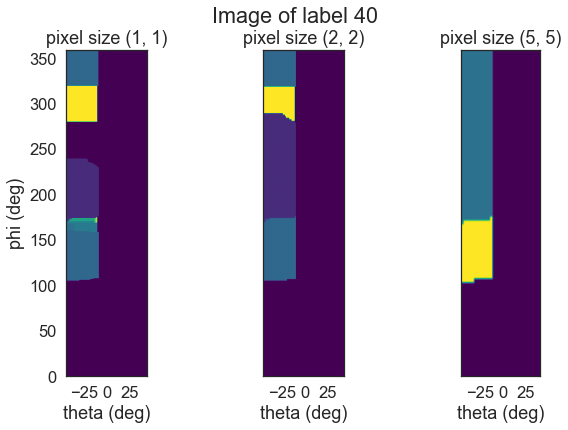

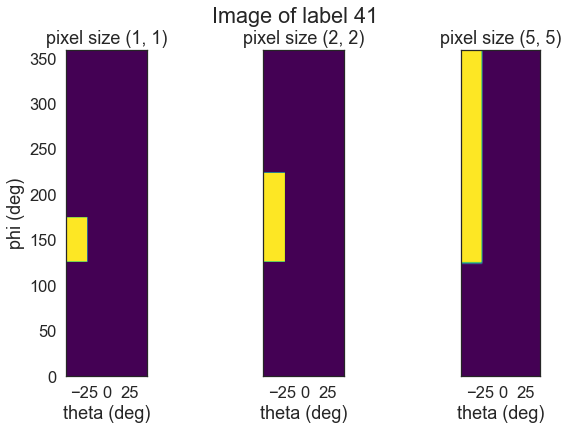

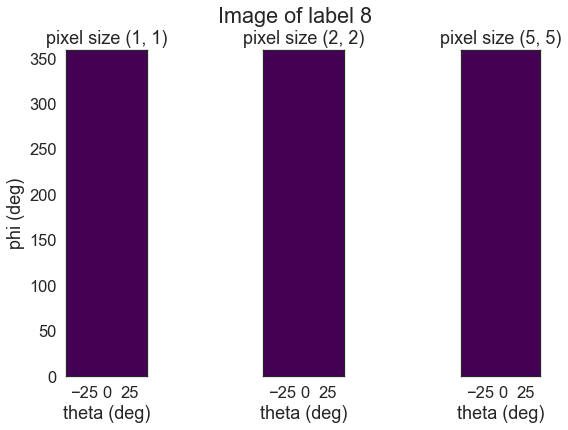

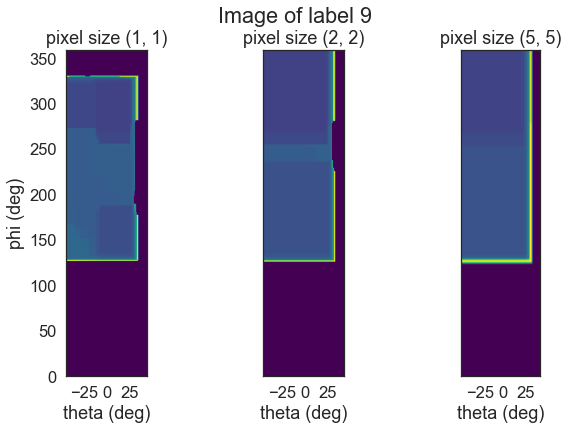

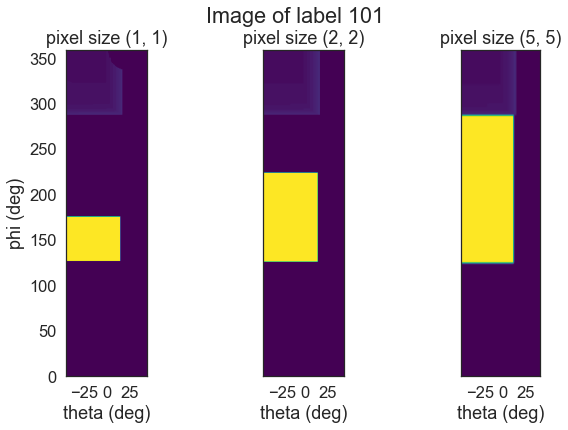

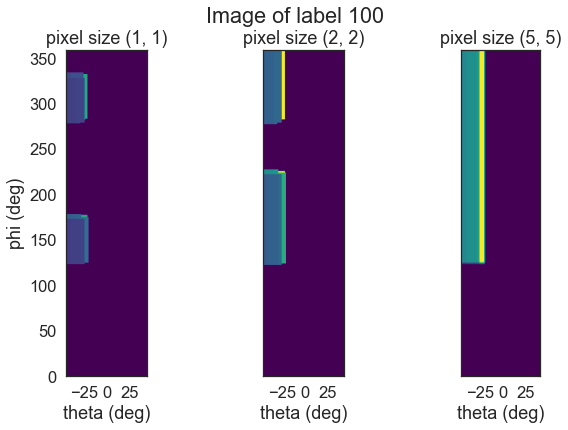

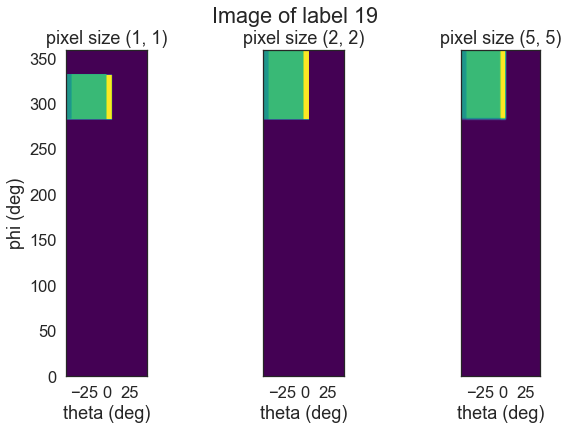

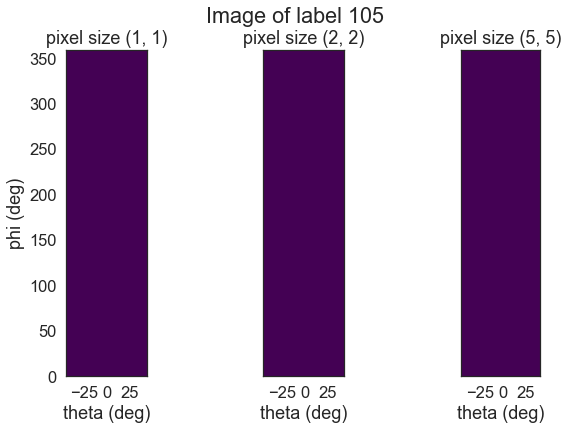

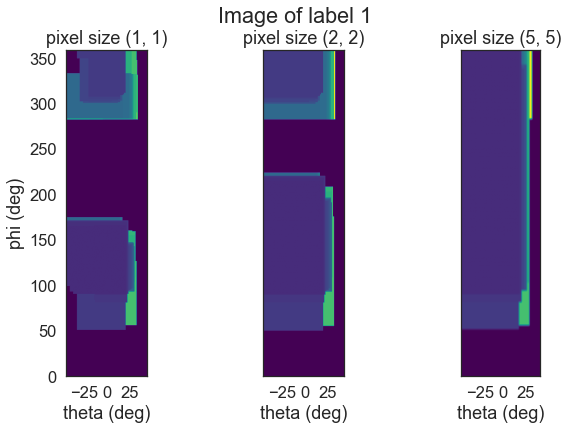

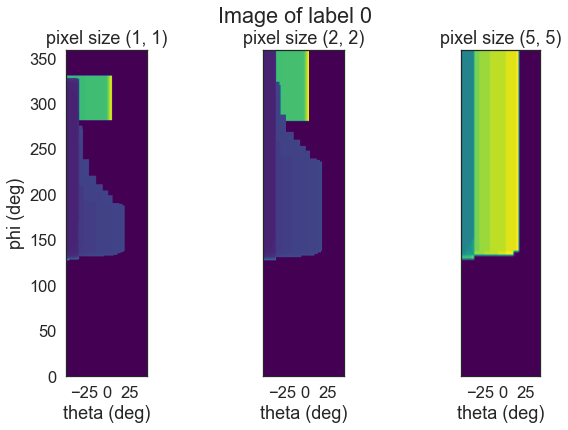

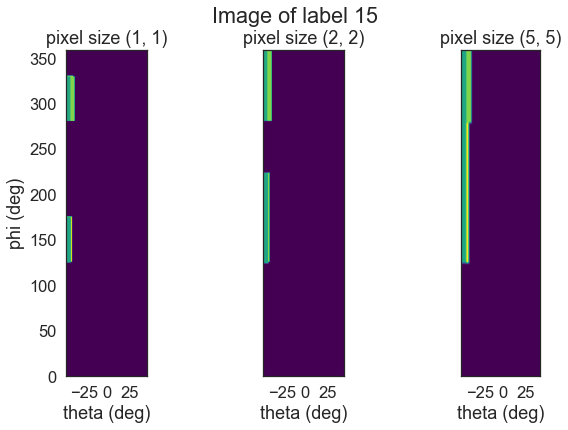

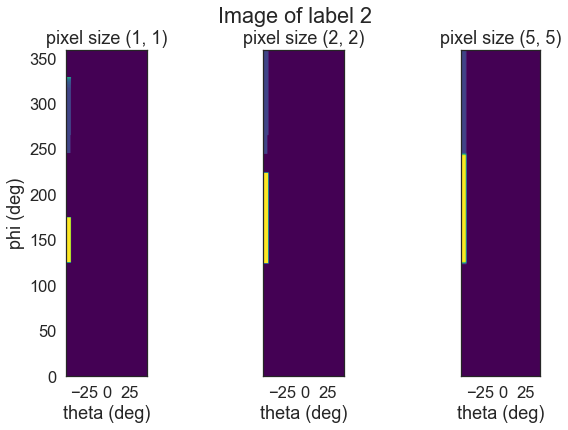

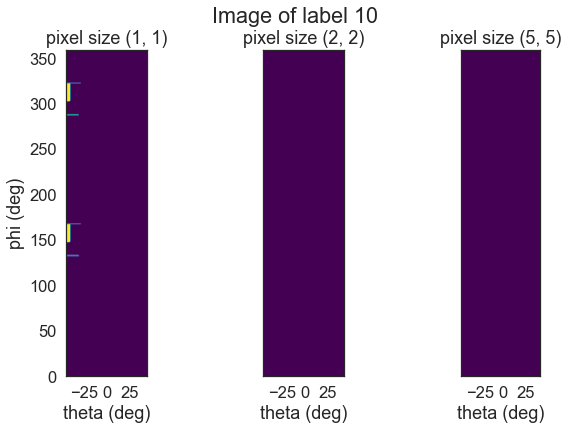

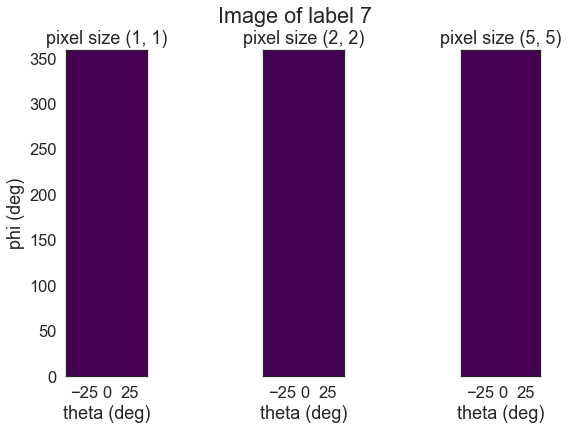

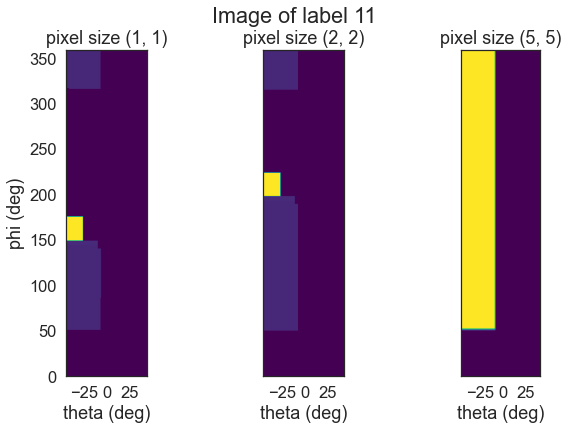

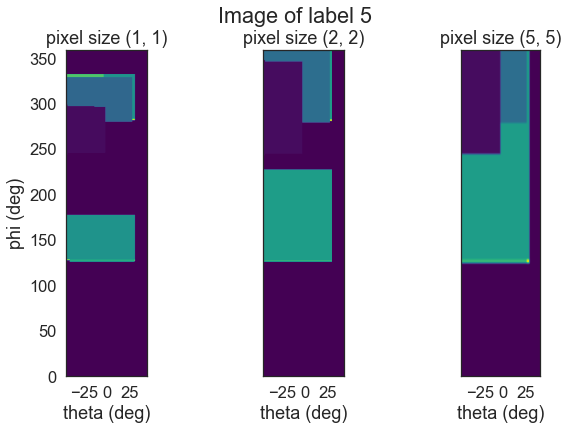

In [14]:
pc_name = "Town01_Opt_ClearSunset_103317935097620212"
pixel_sizes = [(1,1,), (2,2), (5,5,)]

reduced_images_path = "2DRepresentation/1_1/"+pc_name+"/"+pc_name+"_*.txt"
labels_img = glob.glob(reduced_images_path)
labels_img = [int(l.split("/")[-1].split("_")[-1].split(".")[0]) for l in labels_img]

sns.set_theme(font_scale=1.5, palette="mako", style="white")

for ll in labels_img:
    fig, ax = plt.subplots(1,3,figsize=(10, 6))
    for i, ps in enumerate(pixel_sizes):
        rad_pixel = np.deg2rad(ps[0])
        phi_grid = np.arange(0, 2*np.pi, rad_pixel)
        theta_grid = np.arange(-np.pi/4, np.pi/4, rad_pixel)
        reduced_images_path =  "2DRepresentation/"+f"{ps[0]}_{ps[1]}/{pc_name}/{pc_name}_{ll}.txt"
        img = np.loadtxt(reduced_images_path)
        ax[i].imshow(img, cmap="viridis",
        extent=[np.rad2deg(theta_grid[0]), np.rad2deg(theta_grid[-1]), np.rad2deg(phi_grid[0]), np.rad2deg(phi_grid[-1])])
        ax[i].set_title(f"pixel size {ps}")

        if i == 0: ax[i].set_ylabel("phi (deg)")
        if i != 0: 
            ax[i].set_yticklabels([])

        ax[i].set_xlabel("theta (deg)")
        
    fig.suptitle(f"Image of label {ll}")
    plt.show()

### Compression of the 2D images

Now that we have the 2D images, we can compress them by means of any image compression algorithm (e.g. JPEG, PNG, etc.) and store them in a file.

Let us consider, for instance the LZW compression algorithm, which is lossless. 

In this case we consider a compression with maximum table size given by $2^n$ bits, where $n$ takes the values 8,16,32

In [3]:
def LZW_encoder (input_file, n):
    from struct import pack
    
    maximum_table_size = pow(2,int(n))      
    file = open(input_file)                 
    data = file.read()                      

    # Building and initializing the dictionary.
    dictionary_size = 256                   
    dictionary = {chr(i): i for i in range(dictionary_size)}    
    string = ""             # String is null.
    compressed_data = []    # variable to store the compressed data.

    # iterating through the input symbols.
    # LZW Compression algorithm
    for symbol in data:                     
        string_plus_symbol = string + symbol # get input symbol.
        if string_plus_symbol in dictionary: 
            string = string_plus_symbol
        else:
            compressed_data.append(dictionary[string])
            if(len(dictionary) <= maximum_table_size):
                dictionary[string_plus_symbol] = dictionary_size
                dictionary_size += 1
            string = symbol

    if string in dictionary:
        compressed_data.append(dictionary[string])

    # storing the compressed string into a file (byte-wise).
    out = 'LZW/' + input_file.split(".")[0]
    path = os.path.dirname(out)
    if not os.path.exists(path):
        os.makedirs(path)

    output_file = open(out + ".lzw", "wb")
    for d in compressed_data:
        output_file.write(pack('>H',int(d)))
        
    output_file.close()
    file.close()

    results = {
        "input_file": input_file,
        "output_file": out + ".lzw",
        "compression_ratio_%": 100*(1 - len(compressed_data)/len(data)),
        'compressed_data': compressed_data,
    }
    return results

def LZW_decoder (input_file, n):
    from struct import unpack

    maximum_table_size = pow(2,int(n))
    file = open(input_file, "rb")
    compressed_data = []
    next_code = 256
    decompressed_data = ""
    string = ""

    # Reading the compressed file.
    while True:
        rec = file.read(2)
        if len(rec) != 2:
            break
        (data, ) = unpack('>H', rec)
        compressed_data.append(data)

    # Building and initializing the dictionary.
    dictionary_size = 256
    dictionary = dict([(x, chr(x)) for x in range(dictionary_size)])

    # iterating through the codes.
    # LZW Decompression algorithm
    for code in compressed_data:
        if not (code in dictionary):
            dictionary[code] = string + (string[0])
        decompressed_data += dictionary[code]
        if not(len(string) == 0):
            dictionary[next_code] = string + (dictionary[code][0])
            next_code += 1
        string = dictionary[code]

    # storing the decompressed string into a file.
    out = 'LZW/' + input_file.split(".")[0]
    path = os.path.dirname(out)
    if not os.path.exists(path):
        os.makedirs(path)
        
    output_file = open(out + "_decoded.txt", "w")
    decompressed = []

    for data in decompressed_data:
        output_file.write(data)

    output_file.close()
    file.close()


    result = {
        "input_file": input_file,
        "output_file": out + "_decoded.txt",
        "decompressed_data": decompressed,
    }
    return result


In [5]:
# LZW compression for an example image


bits_compression = [6, 8, 10, 12]
compression_results = pd.DataFrame(columns=[ "compression_ratio_%", "label", "bits", "pixel_size"])

pc_name = "Town01_Opt_ClearSunset_103317935097620212"
pixel_sizes = [(1,1,), (2,2), (5,5,)]

reduced_images_path = "2DRepresentation/1_1/"+pc_name+"/"+pc_name+"_*.txt"
labels_img = glob.glob(reduced_images_path)
labels_img = [int(l.split("/")[-1].split("_")[-1].split(".")[0]) for l in labels_img]

sns.set_theme(font_scale=1.5, palette="mako", style="white")


for b in bits_compression:
    for ps in pixel_sizes:
        for cl in labels_img:
            reduced_images_path =  "2DRepresentation/"+f"{ps[0]}_{ps[1]}/{pc_name}/{pc_name}_{cl}.txt"
            
            r = LZW_encoder(reduced_images_path, b)
            d = LZW_decoder(r["output_file"], b)

            original_data = np.loadtxt(reduced_images_path)
            decompressed = np.loadtxt(d["output_file"])

            # check if the original data is equal to the decompressed data
            MSE = np.mean((original_data - decompressed)**2)
            # should be zero because its lossless compression
            compression_results = compression_results.append({
                "compression_ratio_%": r["compression_ratio_%"],
                "label": cl,
                "bits": b,
                "pixel_size": ps,
            }, ignore_index=True)

# save the results
compression_results.to_csv("results/LWZcompression_stats.csv", index=False)


In [45]:
compression_results = pd.read_csv("results/LWZcompression_stats.csv")

compression_results = compression_results.astype({"label": int, "bits": int, "pixel_size": str})
compression_results["pixel_size"] = compression_results["pixel_size"].apply(lambda x: int(x[1]))
compression_results

,compression_ratio_%,label,bits,pixel_size
0,0.000000,40,6,1
1,0.000000,41,6,1
2,0.000000,8,6,1
3,0.000000,9,6,1
4,0.000000,101,6,1
...,...,...,...,...
187,92.102226,2,12,5
188,92.102226,10,12,5
189,92.102226,7,12,5
190,92.102226,11,12,5


Text(0, 0.5, 'Compression ratio (%) of the image')

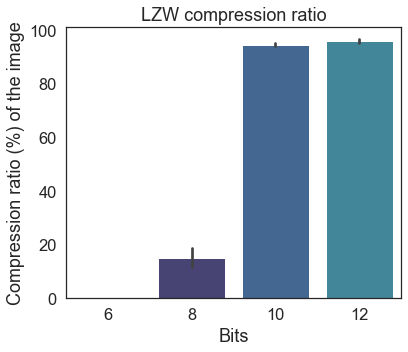

In [42]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(data=compression_results, x="bits", y="compression_ratio_%", ax=ax)
ax.set_title("LZW compression ratio")
ax.set_xlabel("Bits")
ax.set_ylabel("Compression ratio (%) of the image")

### Reconstruction of the 3D point cloud

Finally, we can reconstruct the 3d point cloud from the 2D images by means of an inverse mapping (sphere to cartesian coordinates).

In [10]:
def reconstruct_3D(
        path_to_2d,
        pixel_size = (2,2), 
        theta_range = (-np.pi/4, np.pi/4),
        phi_range = (0, 2*np.pi),
        save=False,
        save_path='reconstructed_PC'
        ):
    """
    path_to_2d: path to the 2d representation of the point cloud
    theta_range: range of theta to consider
    phi_range: range of phi to consider
    pixel_size: size of the pixel in degrees
    save: if true, saves the point cloud as a ply file
    """

    img = np.loadtxt(path_to_2d)

    pixel_size_rad = (np.deg2rad(pixel_size[0]), np.deg2rad(pixel_size[1]))

    phi_grid = [phi_range[0] + i*pixel_size_rad[0] for i in range(img.shape[0])]

    theta_grid = [theta_range[0] + i*pixel_size_rad[1] for i in range(img.shape[1])]


    cartesian_coordinates = []

    # theta ranges -pi/4 to pi/4
    # phi ranges 0 to 2pi, but the backward mapping is not the one of standard spherical coordinates
    # in the forward mapping we did:
    # x>0, y>0 -> phi = 0, phi/2
    # x<0 -> phi = pi/2, pi -> which corresponds to adding pi to the phi obtained from the backward mapping
    # y<0 -> phi = 3pi/2, 2pi -> which corresponds to adding 2pi to the phi obtained from the backward mapping

    # check length of img and phi_grid
    
    for i, phi in enumerate(phi_grid):
        for j, theta in enumerate(theta_grid):
            r = img[i,j]
            
            if r == 0: continue
            
            # when phi is in 0, pi/2, x>0, y>0
            if phi < np.pi/2:
                phi = phi
            # when phi is in pi/2, pi, x<0, y>0
            elif phi < np.pi and phi >= np.pi/2:
                phi = phi - np.pi
            # when phi is in pi, 3pi/2, x<0, y<0
            elif phi < 3*np.pi/2 and phi >= np.pi:
                phi = phi - 2*np.pi

            x = r*np.cos(theta)*np.cos(phi)
            y = r*np.cos(theta)*np.sin(phi)
            z = r*np.sin(theta)
            # print (x, y, z, r , theta, phi, sintheta)
            # plot hist2d in x, y
            print (len(x), len(y))
            fig, ax = plt.subplots(figsize=(6, 5))
            ax.hist2d(x, y, bins=100, cmap='mako')


            cartesian_coordinates.append([x, y, z])
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(cartesian_coordinates)
    if save:
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        o3d.io.write_point_cloud( os.path.join(save_path, path_to_2d.split('/')[-1].split('.')[0] + '.ply'), pcd)
    return pcd


Let us consider the following example, in which we assign a random color to each class.


class 40


IndexError: list index out of range

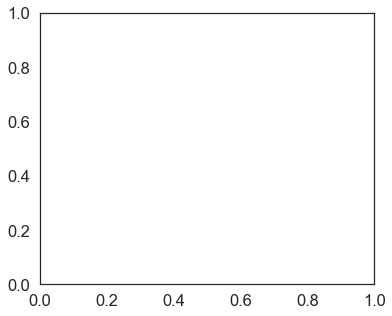

In [12]:
reduced_images_path = "2DRepresentation/1_1/"+pc_name+"/"+pc_name+"_*.txt"
labels_img = glob.glob(reduced_images_path)
labels_img = [int(l.split("/")[-1].split("_")[-1].split(".")[0]) for l in labels_img]

pixel_sizes = [1,2,5]

point_clouds = dict()

for p in pixel_sizes:
    reduced_images_path =  "2DRepresentation/"+f"{p}_{p}/{pc_name}/{pc_name}_{cl}.txt"

    # reconstructed point cloud
    pc = o3d.geometry.PointCloud()
    
    # different color for each class
    colors = dict()
    for i, cl in enumerate(labels_img):
        colors[cl] = np.random.rand(3)

    for cl in labels_img:
        print (f"class {cl}")
        pcd = reconstruct_3D(
            reduced_images_path,
            theta_range=(-np.pi/4, np.pi/4), 
            phi_range=(0, 2*np.pi), 
            pixel_size = (p,p),
        )
        # assign the color to the point cloud, a different color for each class
        pcd.paint_uniform_color(colors[cl])
        pc += pcd 
    
    point_clouds[p] = pc

# save the point clouds
reconstructed_path = f"results/point_clouds_reconstructed"
if not os.path.exists(reconstructed_path):
    os.makedirs(reconstructed_path)

for p in pixel_sizes:
    o3d.io.write_point_cloud( os.path.join(reconstructed_path, f"{pc_name}_{p}.ply"), point_clouds[p])
    

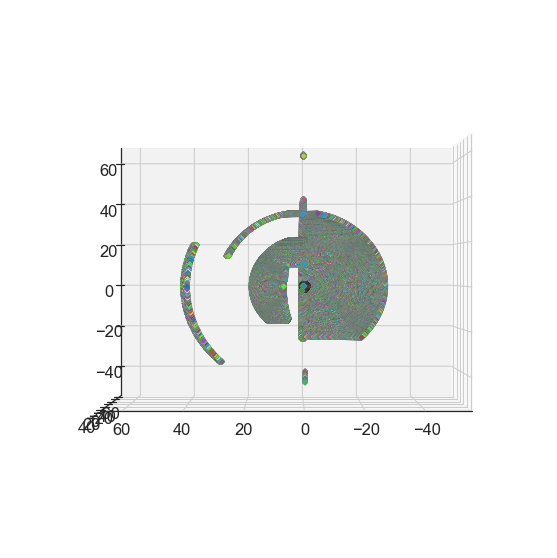

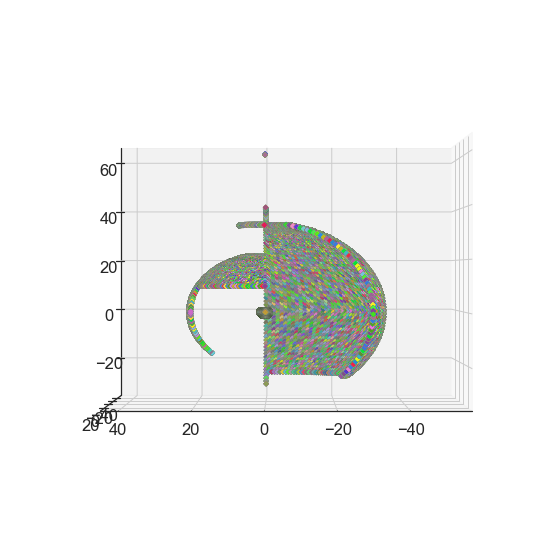

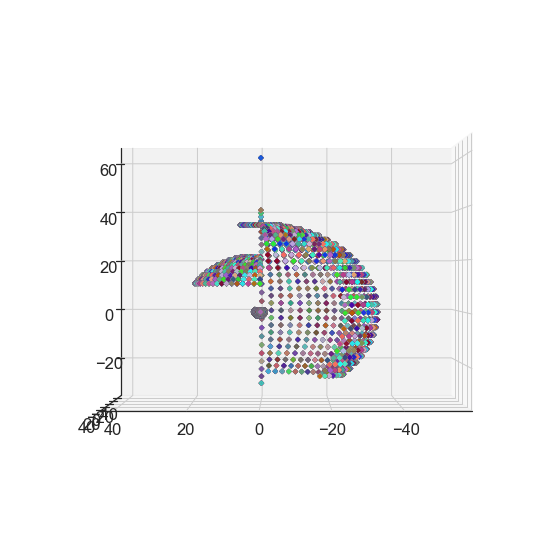

In [82]:
# load point cloud and visualize 
reconstructed_path = f"results/point_clouds_reconstructed"
image_name = 'Town01_Opt_ClearSunset_103317935097620212'


# visualize  the point clouds with pyvista
from pyntcloud import PyntCloud


References:


[1] F. Nardo, D. Peressoni, P. Testolina, M. Giordani, and A. Zanella, “Point cloud compression for efficient data broadcasting: A performance comparison,” IEEE Wireless Communications and Networking Conference (WCNC), Austin, USA, 2022.


[2] Tu, Chenxi & Takeuchi, Eijiro & Carballo, Alexander & Takeda, Kazuya. (2019). Point Cloud Compression for 3D LiDAR Sensor using Recurrent Neural Network with Residual Blocks. 10.1109/ICRA.2019.8794264. 